In [1]:
from sklearn import ensemble, cross_validation, learning_curve, metrics
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import GroupKFold

from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from scipy.stats.kde import gaussian_kde
from scipy.optimize import brentq

import itertools

C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Popova_Va\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are mov

In [2]:
triplexes = pd.read_csv('basetriples2.csv', header=0, sep='\t')

In [3]:
triplexes.head()

,pdb_chain,type,dssrs,bps,dists,same12,local12,longrange12,same23,local23,...,h3p5,b3p5,i3p5,j3p5,lc3p5,li3p5,lp3p5,fl3p5,fed3p5,istriple
0,1b23.cif1_R,120,R.A.22.R.A.36.R.G.48.,-_-_-,33.73_39.19_14.5,0,0,1,0,0,...,0,0,0,0,0,0,0,5,0,0
1,1b23.cif1_R,120,R.A.22.R.G.27.R.G.48.,-_-_-,23.6_22.89_14.5,0,0,1,0,1,...,0,0,0,0,0,0,0,5,0,0
2,1b23.cif1_R,0,R.G.19.R.G.57.R.C.69.,-_-_-,6.31_36.36_36.59,0,0,1,0,0,...,1,0,0,0,1,0,0,4,1,0
3,1b23.cif1_R,0,R.H2U.20.R.U.43.R.5MU.54.,-_-_-,24.47_37.47_24.2,0,0,1,0,0,...,1,0,0,0,1,0,0,7,1,0
4,1b23.cif1_R,0,R.C.44.R.G.52.R.C.62.,-_cWW_-,29.87_10.48_32.96,0,1,0,1,0,...,0,0,0,0,0,0,0,7,1,0


In [4]:
triplexes.shape

(34510, 477)

In [7]:
### !!!!! необходимые данные

triplexes_data = triplexes.iloc[:, 5:475]
triplexes_target = triplexes.iloc[:, 476]

In [5]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap="YlGnBu"):  #"YlGnBu" plt.cm.gray_r
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    print("CONFUSION MATRIX")
    print(df_confusion)
    a = itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1]))
    for i, j in itertools.product(range(df_confusion.shape[0]), range(df_confusion.shape[1])):
        if i == 2:
            i_ = 'All'
        else:
            i_ = i
        if j == 2:
            j_ = 'All'
        else:
            j_ = j
        plt.text(i, j, df_confusion[i_][j_], horizontalalignment="center", color='black')
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    
    
    
def probability_density(y_prob, y):
    
    kde1 = gaussian_kde(y_prob[y == 1])
    kde2 = gaussian_kde(y_prob[y == 0])
    
    x1 = np.linspace(np.min(y_prob[y == 1]),np.max(y_prob[y == 1]),500)
    x2 = np.linspace(np.min(y_prob[y == 0]),np.max(y_prob[y == 0]),500)
    
    try:
        treshold = brentq(lambda x : kde1(x) - kde2(x), x2[np.argmax(kde1(x1))], x1[np.argmax(kde2(x2))])
    except ValueError:
        treshold = 0.5
        
    plt.fill_between(x1,kde1(x1),0, color='darkblue', alpha = 0.5, label = 'Triplexes')
    plt.fill_between(x2,kde2(x2), 0, color='darkgrey', alpha = 0.5, label = 'Non-triplexes')
    plt.axvline(x1[np.argmax(kde1(x1))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(x2[np.argmax(kde2(x2))], color='black', linestyle='--', alpha = 0.5)
    plt.axvline(treshold, color='black', linestyle='-.', alpha = 0.7, label = str(round(treshold,2)))
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title('Probability Distributions')
    plt.xlabel('Probabilities')


In [9]:
#используемая модель
rf_classifier_cv = ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=1)

TEST_GROUPS Counter({'3j7q.cif1_5': 1318, '3j79.cif1_A': 966, '3j7p.cif1_S2': 764, '6ha1.cif1_a': 644, '6az1.cif1_1': 585, '3j7a.cif1_A': 483, '5xyi.cif1_2': 429, '6d9j.cif1_2': 383, '1u6b.cif1_B': 78, '5fdv.cif1_1B': 67, '4wf9.cif1_Y': 62, '4gxy.cif1_A': 58, '6ek0.cif1_L7': 53, '5xxb.cif1_3': 47, '5xym.cif1_B': 44, '6ha1.cif1_B': 41, '4qk8.cif1_A': 37, '3f2x.cif1_X': 34, '4rdx.cif1_C': 33, '2der.cif1_D': 32, '4mgn.cif1_A': 31, '5lys.cif1_B': 30, '3dil.cif1_A': 28, '4qlm.cif1_A': 28, '5d8h.cif1_A': 26, '5hr7.cif1_D': 26, '1j1u.cif1_B': 25, '5aj0.cif1_Bv': 25, '5mrc.cif1_bb': 25, '3eph.cif1_E': 24, '4mgn.cif1_B': 24, '6gaw.cif1_BB': 23, '5u3g.cif1_B': 22, '5jup.cif1_EC': 21, '6az3.cif1_7': 21, '3npq.cif1_A': 20, '4lvw.cif1_A': 20, '4y1m.cif1_B': 20, '3tup.cif1_T': 19, '5e81.cif1_1K': 19, '6ek0.cif1_L8': 19, '3la5.cif1_A': 18, '4gcw.cif1_B': 18, '5ud5.cif1_C': 18, '1i6u.cif1_C': 17, '1mms.cif1_C': 16, '4lx6.cif1_A': 15, '4v9k.cif1_AW': 15, '4wsm.cif1_3L': 12, '1s03.cif1_B': 11, '3e5c.cif

type                                 111
dssrs    1.5MC.2061.1.G.2163.1.MA6.2185.
bps                            cWW_tSS_-
dists                    10.59_7.84_5.86
Name: 26338, dtype: object

PROBA:  [0.52242001 0.47757999]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                             110
dssrs    1.U.1538.1.G.1552.1.G.1553.
bps                          t.W_-_-
dists               12.75_8.74_19.02
Name: 26407, dtype: object

PROBA:  [0.18641394 0.81358606]

equal


equal





equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  6ek0.cif1_L7
[[45  0]
 [ 0  8]]



equal


equal


equal

type                             112
dssrs    C.A.1084.C.G.1089.C.U.1101.
bps                          -_c.W_-
dists              20.36_11.94_22.28
Name: 375, dtype: object

PROBA:  [0.40073404 0.59926596]

equal

type                             112
dssrs    C.C.1092.C.G.1099.C.U.1101.
bps                          cWW_-_-
dists               10.37_10.44_7.24
Name: 376, dtype: object

PROBA:  [0.44170011 0.55829989]

equal


equal


equal


equal


equal


equal


equal


equal


equa



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                        111
dssrs    A.A.26.A.G.59.A.A.335.
bps                   cWW_tSW_-
dists          13.04_11.56_9.96
Name: 2386, dtype: object

PROBA:  [0.62714503 0.37285497]

equal

type                        111
dssrs    A.U.27.A.A.58.A.A.335.
bps                   cWW_-_cSW
dists          10.56_12.75_5.54
Name: 2387, dtype: object

PROBA:  [0.56105453 0.43894547]

equal


equal


equal


equal

type             

type                             110
dssrs    A.U.3186.A.U.3221.A.U.3228.
bps                          cWW_-_-
dists              10.95_24.03_25.38
Name: 2570, dtype: object

PROBA:  [0.2346485 0.7653515]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


eq

type                                111
dssrs    S2.C.1562.S2.G.1563.S2.C.1572.
bps                           cWH_cWW_-
dists                  6.09_10.68_14.27
Name: 3903, dtype: object

PROBA:  [0.77463495 0.22536505]

equal

type                                111
dssrs    S2.U.1616.S2.A.1620.S2.U.1662.
bps                           tWW_cWW_-
dists                  10.27_10.38_4.37
Name: 3904, dtype: object

PROBA:  [0.55397906 0.44602094]

equal


equal

type                                111
dssrs    S2.A.1695.S2.C.1703.S2.A.1832.
bps                           -_cWW_tWS
dists                     7.5_10.49_8.9
Name: 3906, dtype: object

PROBA:  [0.74387633 0.25612367]

equal


equal

type                                111
dssrs    S2.C.1705.S2.G.1829.S2.A.1851.
bps                           cWW_tSS_-
dists                   10.76_8.22_5.55
Name: 3908, dtype: object

PROBA:  [0.51176275 0.48823725]

equal


equal

type                                111
dssrs    S2.U.1720.S2.U.1812



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5xyi.cif1_2
[[368   0]
 [ 15  46]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  6ha1.cif1_a
[[550   2]
 [ 28  64]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


type                       111
dssrs    B.G.8.B.U.48.B.C.101.
bps                cWW_tWS_cWW
dists           8.2_7.99_10.59
Name: 12630, dtype: object

PROBA:  [0.73393413 0.26606587]

equal

type                       111
dssrs    B.A.11.B.C.43.B.G.65.
bps                  -_cWW_tWS
dists          5.89_10.46_8.49
Name: 12631, dtype: object

PROBA:  [0.67339268 0.32660732]

equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  4y1m.cif1_B
[[17  0]
 [ 2  1]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                          111
dssrs    Bv.U.16.Bv.U.20.Bv.U.59.
bps                   cSH_tWW_tWW
dists             9.66_10.69_8.21
Name: 13943, dtype: object

PROBA:  [0.72359937 0.27640063]

equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5aj0.cif1_Bv
[[21  0]
 [ 1  3]]



equal


equal


equal


equal


equal






equal


equal

type                       112
dssrs    C.A.10.C.G.12.C.C.27.
bps                    -_cWW_-
dists         9.25_10.61_13.14
Name: 225, dtype: object

PROBA:  [0.41072279 0.58927721]

equal


equal

type                       112
dssrs    C.U.25.C.C.27.C.U.28.
bps                    cSH_-_-
dists          9.33_5.85_12.11
Name: 227, dtype: object

PROBA:  [0.43521412 0.56478588]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  1i6u.cif1_C
[[12  2]
 [ 0  3]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       111
dssrs    C.U.17.C.U.54.C.A.58.
bps                  -_tWH_c.W
dists          11.28_9.48_9.49
Name: 9439, dtype: object

PROBA:  [0.70115249 0.29884751]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal



PROBA:  [0.56522601 0.43477399]

equal

type                             111
dssrs    5.A.1391.5.A.4348.5.G.4364.
bps                        -_cWW_cWS
dists               15.38_13.63_5.45
Name: 4930, dtype: object

PROBA:  [0.71915132 0.28084868]

equal


equal

type                             111
dssrs    5.C.1405.5.C.1411.5.G.1412.
bps                        -_cWH_cWW
dists                14.68_6.0_10.83
Name: 4932, dtype: object

PROBA:  [0.74652346 0.25347654]

equal


equal

type                             111
dssrs    5.U.1438.5.G.1444.5.G.2099.
bps                      cWW_cWW_cWH
dists               12.78_13.84_7.22
Name: 4934, dtype: object

PROBA:  [0.78444006 0.21555994]

equal


equal


equal

type                             111
dssrs    5.C.1478.5.G.1479.5.C.1486.
bps                        cWH_cWW_-
dists               6.28_10.52_12.69
Name: 4937, dtype: object

PROBA:  [0.68285777 0.31714223]

equal


equal


equal

type                             111
dssrs    5.C.1



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                          110
dssrs    5.G.364.5.U.365.5.G.415.
bps                       cSH_-_-
dists            6.54_29.01_32.18
Name: 5212, dtype: object

PROBA:  [0.31227462 0.68772538]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equ

AUC_TRAIN =  0.8918075275804445

AUC =  0.8419867575803788


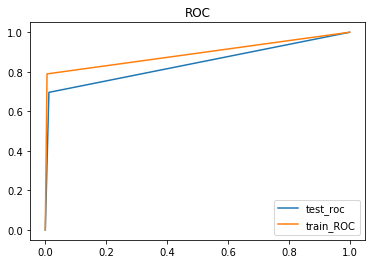


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5886
          1       0.91      0.70      0.79      1016

avg / total       0.94      0.95      0.94      6902

ACCURACY =  0.945088380179658
-----------------
TEST_GROUPS Counter({'4v9f.cif1_0': 1152, '4ioa.cif1_X': 992, '5mrc.cif1_A': 832, '6d9j.cif1_5': 727, '5ool.cif1_A': 572, '3jam.cif1_2': 506, '5mrc.cif1_aa': 419, '5t5h.cif1_A': 340, '4p95.cif1_A': 92, '1u9s.cif1_A': 73, '4v9f.cif1_9': 63, '4ioa.cif1_Y': 59, '3j79.cif1_B': 55, '4r4v.cif1_A': 48, '4plx.cif1_A': 46, '5fjc.cif1_A': 42, '6d90.cif1_4': 38, '4oqu.cif1_A': 36, '3u4m.cif1_B': 33, '6d9j.cif1_7': 33, '4yco.cif1_D': 31, '4wj4.cif1_B': 29, '5e6m.cif1_C': 29, '2du3.cif1_D': 27, '2gdi.cif1_X': 26, '4p5j.cif1_A': 26, '1il2.cif1_C': 25, '1n78.cif1_C': 25, '3q3z.cif1_V': 25, '1u0b.cif1_A': 24, '2csx.cif1_C': 24, '4qei.cif1_C': 24, '4lck.cif1_B': 22, '3j7q.cif1_8': 21, '5hr6.cif1_C': 21, '2d6f.cif1_F': 20, '4fen.cif1_B':

 [ 0  3]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equ

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5mrc.cif1_A
[[711   2]
 [ 41  78]]



equal


equal


equal


equal


equal


equal


equal


equal

type                       112
dssrs    X.G.19.X.C.22.X.G.37.
bps                    -_cWW_-
dists        14.67_10.45_20.95
Name: 1109, dtype: object

PROBA:  [0.37861263 0.62138737]

equal


equal


equal


equal


equal


equal


equal


equal

type                       111
dssrs    X.G.21.X.C.38.X.U.71.
bps                  cWW_-_cSS
dists          10.85_8.79_6.87
Name: 1117, dtype: object

PROBA:  [0.7585151 0.2414849]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  2gdi.cif1_X
[[21  1]
 [ 1  3]]



equal


equal


equal

type                            112
dssrs    Y.U.508.Y.2MG.510.Y.C.525.
bps                         -_cWW_-
dists              13.81_10.6_16.59
Name: 1066, dtype: obje



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                      111
dssrs    A.G.6.A.C.50.A.A.65.
bps                 cWW_-_tSS
dists         10.81_5.64_8.12
Name: 9165, dtype: object

PROBA:  [0.63978306 0.36021694]

equal

type                      111
dssrs    A.U.7.A.U.47.A.A.66.
bps                 -_cWW_cWH
dists        14.81_10.03_8.36
Name: 9166, dtype: object

PROBA:  [0.59865348 0.40134652]

equal

type                      111
dssrs    A.U.8.A.U.46.A.A.67.
bps                 -_cWW_cWH
dists          15.12_10.6_8.3
Name: 9167, dtype: object

PROBA:  [0.53577398 0.46422602]

equal

type                      111
dssrs    A.U.9.A.U.45.A.A.68.
bps                 -_cWW_cWH
dists        15.06_10.77_8.02
Name: 9168, dtype: object

PROBA:  [0.54030422 0.45969578]

equal

type                       111
dssrs    A.U.10.A.U.44.A.A.6


type                           111
dssrs    A.G.404.A.U.981.A.A.1093.
bps                      cSS_cWW_-
dists             5.55_10.15_12.72
Name: 21859, dtype: object

PROBA:  [0.5280279 0.4719721]

equal


equal

type                           111
dssrs    A.C.479.A.G.755.A.A.1623.
bps                      cWW_cSH_-
dists              10.25_4.67_9.03
Name: 21861, dtype: object

PROBA:  [0.80151373 0.19848627]

equal


equal

type                             111
dssrs    A.C.767.A.G.780.A.OMG.1659.
bps                        cWW_-_tSW
dists                10.36_7.28_9.29
Name: 21863, dtype: object

PROBA:  [0.75240149 0.24759851]

equal


equal


equal

type                            111
dssrs    A.C.991.A.G.1068.A.G.1775.
bps                       cWW_-_cSS
dists              10.22_13.27_5.98
Name: 21866, dtype: object

PROBA:  [0.72632264 0.27367736]

equal

type                            111
dssrs    A.G.993.A.U.1066.A.A.1927.
bps                       cWW_-_cSW
dists            

type                             110
dssrs    5.G.3868.5.U.3920.5.A.4381.
bps                          -_cWW_-
dists              61.83_10.92_63.05
Name: 28030, dtype: object

PROBA:  [0.49289348 0.50710652]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal



type                             111
dssrs    X.U.1286.X.C.1675.X.G.1985.
bps                        -_cWW_cWS
dists               12.28_10.44_7.46
Name: 7683, dtype: object

PROBA:  [0.71835523 0.28164477]

equal


equal


equal

type                             111
dssrs    X.A.1300.X.C.1665.X.G.1992.
bps                        cWS_cWW_-
dists               9.66_10.77_11.81
Name: 7686, dtype: object

PROBA:  [0.6496703 0.3503297]

equal

type                             111
dssrs    X.U.1301.X.U.1339.X.G.1664.
bps                        tWW_-_tSS
dists                 8.82_8.05_7.95
Name: 7687, dtype: object

PROBA:  [0.91647613 0.08352387]

equal


equal


equal


equal


equal


equal


equal


equal


equal

type                             111
dssrs    X.G.1337.X.C.1343.X.A.1632.
bps                        cWW_-_cSW
dists               10.54_14.54_7.44
Name: 7696, dtype: object

PROBA:  [0.52670221 0.47329779]

equal

type                             111
dssrs    X.A.1354.X.U.140



equal


equal


equal

type                       120
dssrs    A.U.29.A.G.46.A.G.88.
bps                      -_-_-
dists         6.84_21.94_21.16
Name: 8979, dtype: object

PROBA:  [0.41013229 0.58986771]

equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       112
dssrs    A.C.27.A.G.46.A.A.90.
bps                    cWW_-_-
dists          10.6_19.4_20.05
Name: 8988, dtype: object

PROBA:  [0.35024665 0.64975335]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  4oqu.cif1_A
[[28  2]
 [ 0  6]]



equal


equal


equal


equal


equal


equal


equal


equal

type                       112
dssrs    A.A.10.A.U.25.A.A.46.
bps                    cWW_-_-
dists         10.09_16.76_11.3
Name: 621, dtype: object

PROBA:  [0.30467498 0.69532502]

equal


equal


equal

type          

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5mrc.cif1_aa
[[359   0]
 [ 15  45]]



equal

type                   



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                      123
dssrs    C.A.9.C.C.11.C.G.22.
bps                     -_-_-
dists        10.24_16.34_9.78
Name: 1007, dtype: object

PROBA:  [0.47272074 0.52727926]

equal


equal


equal


equal

CONFUSION MATRIX By chain:  2csx.cif1_C
[[19  1]
 [ 0  4]]



equal


equal


equal

CONFUSION MATRIX By chain:  5ob3.cif1_A
[[2 0]
 [0 1]]



equal


equal

type                         0
dssrs    W.G.53.W.G.67.W.G.69.
bps                      -_-_-
dists        25.58_11.03_30.19
Name: 6299, dtype: object

PROBA:  [0.23959205 0.76040795]

equal


equal


equal


equal


equal


equal

type                       100
dssrs    W.G.49.W.G.50.W.G.69.
bps                      -_-_-
dists         5.71_25.22_20.74
Name: 6305, dtype: object

PROBA:  [0.23857164 0.76142836]

equal


equal

type                      111
dssrs    W

type                             111
dssrs    0.C.1810.0.G.2730.0.C.2752.
bps                        -_cWW_cWS
dists               12.71_10.79_8.05
Name: 11088, dtype: object

PROBA:  [0.57560548 0.42439452]

equal

type                             111
dssrs    0.A.1811.0.G.2731.0.C.2751.
bps                        tWS_cWW_-
dists               9.93_10.63_10.12
Name: 11089, dtype: object

PROBA:  [0.59500328 0.40499672]

equal

type                             111
dssrs    0.G.1849.0.C.1882.0.A.1941.
bps                        cWW_-_tSW
dists                 10.6_7.48_8.89
Name: 11090, dtype: object

PROBA:  [0.64663328 0.35336672]

equal


equal

type                             111
dssrs    0.A.1857.0.U.2246.0.A.2255.
bps                        cWS_cWW_-
dists                9.4_10.62_11.63
Name: 11092, dtype: object

PROBA:  [0.67234217 0.32765783]

equal


equal


equal


equal


equal

type                             111
dssrs    0.A.1910.0.G.2128.0.U.2265.
bps                   



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5ool.cif1_A
[[490   0]
 [ 31  51]]



equal

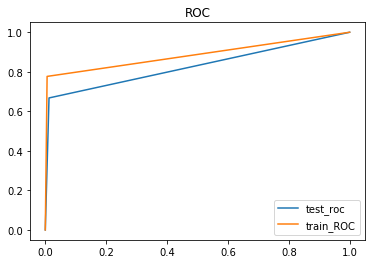


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5888
          1       0.90      0.67      0.77      1014

avg / total       0.94      0.94      0.94      6902

ACCURACY =  0.9407418139669661
-----------------
TEST_GROUPS Counter({'4y4o.cif1_2A': 1113, '6eri.cif1_AA': 1011, '5xxb.cif1_1': 844, '5xy3.cif1_1': 762, '6ek0.cif1_S2': 550, '5xxu.cif1_2': 474, '5ngm.cif1_Aa': 461, '5t5h.cif1_B': 282, '6gaz.cif1_AA': 277, '3j7o.cif1_7': 58, '5xy3.cif1_3': 54, '3mxh.cif1_R': 47, '4kqy.cif1_A': 45, '6eri.cif1_Ax': 42, '2qwy.cif1_C': 37, '2r8s.cif1_R': 34, '3v7e.cif1_C': 33, '5t83.cif1_A': 33, '5ccb.cif1_N': 31, '1mfq.cif1_A': 30, '4yye.cif1_C': 29, '6d9j.cif1_8': 27, '4v8n.cif1_CV': 26, '6az3.cif1_4': 26, '3al0.cif1_E': 25, '3d2v.cif1_A': 25, '6eri.cif1_AB': 25, '3amu.cif1_B': 24, '3kfu.cif1_L': 24, '5nwq.cif1_A': 24, '5ool.cif1_B': 22, '5ktj.cif1_A': 21, '5oql.cif1_2': 21, '4v90.cif1_AV': 20, '5xxb.cif1_4': 20, '1y26.cif1_X': 19, '3g



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal




equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal




equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       111
dssrs    1.A.37.1.U.42.1.G.92.
bps                  -_tWW_cSW
dists          11.66_11.58_7.8
Name: 25017, dtype: object

PROBA:  [0.66130048 0.33869952]

equal


equal


type                             111
dssrs    1.C.1805.1.U.2376.1.A.2382.
bps                        -_cWW_tWS
dists                  9.8_12.0_9.77
Name: 25089, dtype: object

PROBA:  [0.60654009 0.39345991]

equal


equal


equal

type                             111
dssrs    1.A.1827.1.G.2416.1.C.2425.
bps                        cWS_cWW_-
dists               6.14_10.77_12.51
Name: 25092, dtype: object

PROBA:  [0.63411343 0.36588657]

equal

type                             111
dssrs    1.C.1906.1.G.2446.1.A.2670.
bps                        cWW_tSW_-
dists               10.99_9.38_11.73
Name: 25093, dtype: object

PROBA:  [0.58934231 0.41065769]

equal

type                             111
dssrs    1.C.1907.1.G.2445.1.A.2669.
bps                        cWW_-_cSW
dists               11.05_11.85_9.76
Name: 25094, dtype: object

PROBA:  [0.58137419 0.41862581]

equal


equal

type                             111
dssrs    1.G.1914.1.A.2401.1.C.2439.
bps                        tH._-_cWW
d



equal


equal


equal


equal


equal


equal


equal

type                             112
dssrs    1.G.2942.1.C.2968.1.G.3062.
bps                          cWW_-_-
dists              10.68_41.36_32.67
Name: 23506, dtype: object

PROBA:  [0.37233116 0.62766884]

equal


equal

type                            112
dssrs    1.A.357.1.G.2527.1.U.2917.
bps                         -_cWW_-
dists              54.24_10.29_62.8
Name: 23508, dtype: object

PROBA:  [0.46130251 0.53869749]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                            112
dssrs    1.G.333.1.C.2741.1.G.2759.
bps                         -_cWW_-
dists             81.14_10.68_89.08
Name: 23551, dtype: object




equal


equal


equal


equal


equal


equal

type                          112
dssrs    AV.U.12.AV.C.13.AV.A.23.
bps                       -_-_cWH
dists             5.11_8.91_11.24
Name: 10242, dtype: object

PROBA:  [0.41538863 0.58461137]

equal


equal


equal


equal


equal

type                         111
dssrs    AV.U.8.AV.A.14.AV.A.21.
bps                  tWH_cWS_tSW
dists            9.33_10.72_8.69
Name: 10247, dtype: object

PROBA:  [0.54907274 0.45092726]

equal

type                         111
dssrs    AV.A.9.AV.U.12.AV.A.23.
bps                    -_cWH_tHW
dists          11.03_11.24_12.14
Name: 10248, dtype: object

PROBA:  [0.60896457 0.39103543]

equal

type                          111
dssrs    AV.C.13.AV.G.22.AV.G.46.
bps                     cWW_tHW_-
dists           10.64_10.61_14.56
Name: 10249, dtype: object

PROBA:  [0.79566297 0.20433703]

equal


equal


equal


equal


equal

type                        123
dssrs    AV.U.8.AV.A.9.AV.G.46.
bps            


equal


equal


equal


equal


equal

type                       112
dssrs    A.A.19.A.G.29.A.A.32.
bps                    -_tSW_-
dists         13.95_9.32_15.86
Name: 18603, dtype: object

PROBA:  [0.48566335 0.51433665]

equal


equal


equal


equal


equal


equal


equal

type                      111
dssrs    A.C.6.A.U.18.A.G.34.
bps               tWH_cWS_tWW
dists       12.43_11.47_10.23
Name: 18610, dtype: object

PROBA:  [0.82655505 0.17344495]

equal

type                      111
dssrs    A.A.8.A.G.17.A.C.36.
bps                 -_cWW_cWH
dists       15.27_10.78_12.02
Name: 18611, dtype: object

PROBA:  [0.60915712 0.39084288]

equal

type                       111
dssrs    A.C.20.A.G.29.A.A.32.
bps                  cWW_tSW_-
dists         10.75_9.32_11.08
Name: 18612, dtype: object

PROBA:  [0.59487816 0.40512184]

equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5nwq.cif1_A
[[20  1]
 [ 3  0]]



equal


equal


equal


equal


equal


equal


equal


eq



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  4y4o.cif1_2A
[[954   0]
 [ 50 109]]



type                                111
dssrs    AA.U.2523.AA.G.2593.AA.G.2600.
bps                           tHH_-_cWW
dists                  10.4_16.04_10.22
Name: 31069, dtype: object

PROBA:  [0.62886038 0.37113962]

equal

type                                111
dssrs    AA.C.2524.AA.G.2570.AA.G.2599.
bps                         tWS_cSS_cWW
dists                   8.94_4.57_10.62
Name: 31070, dtype: object

PROBA:  [0.53575346 0.46424654]

equal


equal


equal


equal

type                                111
dssrs    AA.C.2643.AA.G.2795.AA.U.2797.
bps                           cWW_cSH_-
dists                  10.61_6.99_12.43
Name: 31074, dtype: object

PROBA:  [0.82445155 0.17554845]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equ


equal

CONFUSION MATRIX By chain:  4kqy.cif1_A
[[38  0]
 [ 3  4]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                       123
dssrs    N.G.10.N.A.23.N.G.45.
bps                    -_-_cHS
dists         15.83_12.81_8.81
Name: 14465, dtype: object

PROBA:  [0.49421948 0.50578052]

equal


equal

CONFUSION MATRIX By chain:  5ccb.cif1_N
[[25  1]
 [ 0  5]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                          111
dssrs    CV.C.11.CV.C.27.CV.G.47.
bps                     cWW_-_...
dists             7.48_14.36_11.9
Name: 10226, dtype: object

PROBA:  [0.70968046 0.29031954]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  4v8n.c

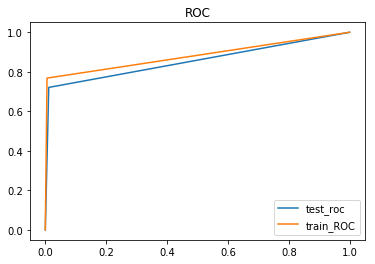


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5888
          1       0.92      0.72      0.81      1014

avg / total       0.95      0.95      0.95      6902

ACCURACY =  0.949290060851927
-----------------
TEST_GROUPS Counter({'5j7l.cif1_DA': 1099, '6ha1.cif1_A': 1023, '5tbw.cif1_1': 932, '4v88.cif1_A6': 640, '5o5j.cif1_A': 574, '6gaw.cif1_BA': 539, '6az3.cif1_1': 397, '3j9m.cif1_AA': 320, '5oql.cif1_1': 158, '1nbs.cif1_B': 65, '3igi.cif1_A': 62, '5j7l.cif1_DB': 56, '6az3.cif1_8': 53, '5ml7.cif1_B': 46, '3ivk.cif1_M': 43, '3hhn.cif1_E': 38, '1yfg.cif1_A': 37, '4uyk.cif1_R': 34, '1h4s.cif1_T': 33, '4lck.cif1_F': 32, '4aob.cif1_A': 30, '4y1j.cif1_A': 29, '3wqy.cif1_C': 28, '6cb3.cif1_B': 27, '3wfs.cif1_A': 26, '1fir.cif1_A': 25, '1qtq.cif1_B': 25, '3ski.cif1_A': 25, '6ck5.cif1_A': 25, '1gax.cif1_D': 24, '3j79.cif1_C': 24, '5axm.cif1_P': 23, '3d0u.cif1_A': 21, '6az3.cif1_5': 21, '1ser.cif1_T': 20, '3oxe.cif1_A': 20, '3w3s.ci



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal




equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  3j79.cif1_C
[[20  0]
 [ 0  4]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  3wfs.cif1_A
[[22  0]
 [ 0  4]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equa



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                          111
dssrs    1.A.649.1.C.852.1.G.871.
bps                     -_cWW_tSS
dists             5.81_10.86_8.06
Name: 20944, dtype: object

PROBA:  [0.70770839 0.29229161]

equal


equal

type                          111
d



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                                110
dssrs    BA.G.1067.BA.A.1233.BA.U.1260.
bps                             -_-_cWW
dists                 41.42_37.91_10.26
Name: 32355, dtype: object

PROBA:  [0.48912346 0.51087654]

equal

type                              110
dssrs    BA.U.198.BA.A.637.BA.A.1038.
bps                           cWW_-_-
dists               10.79_45.63_37.24
Name: 32356, dtype: object

PROBA:  [0.42548599 0.57451401]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                             110
dssrs    BA.G.113.BA.A.116.BA.G.128.
bps                          


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal





equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                         111
dssrs    A.A.38.A.U.488.A.A.659.
bps                    cWW_cSH_-
dists            10.67_8.54_13.0
Name: 34067, dtype: object

PROBA:  [0.60006285 0.39993715]

equal

type                         111
dssrs    A.C.39.A.G.487.A.A.659.
bps                    cWW_-_cSW
dists           10.72_11.15_9.09
Name: 34068, dtype: object

PROBA:  [0.57146776 0.42853224]

equal


equal


equal


equal


equal


equal

type                        111
dssrs    A.A.65.A.U.89.A.C.503.
bps                   cWW_-_cSW
dists          10.51_11.02_7.81
Name: 34074, dtype: object

PROBA:  [0.886193 0.113807]

equal

type                         111
dssrs    A.G.80.A.C.105.A.A.337.
bps                    cWW_-_tSS
dists       


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal





equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal






equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal




equal

type                                111
dssrs    DA.U.1709.DA.A.1749.DA.G.2859.
bps                           cWW_-_cSS
dists                  10.48_12.65_5.58
Name: 15588, dtype: object

PROBA:  [0.58139634 0.41860366]

equal


equal


equal


equal

type                                111
dssrs    DA.C.1793.DA.G.1826.DA.A.1900.
bps                         cWW_cSS_tSW
dists                   10.74_7.77_8.97
Name: 15592, dtype: object

PROBA:  [0.6561592 0.3438408]

equal


equal


equal


equal


equal


equal


equal


equal


equal

type                                111
dssrs    DA.A.1952.DA.U.2548.DA.A.2560.
bps                           -_cWW_cWS
dists                  12.98_10.67_5.45
Name: 15601, dtype: object

PROBA:  [0.54812042 0.45187958]

equal


equal


equal

type                                111
dssrs    DA.A.1966.DA.G.2592.DA.C.2601.
bps                           cWS_cWW_-
dists                  6.15_10.76_13.06
Name: 15604, dtype: object

PROBA:  [0.544049

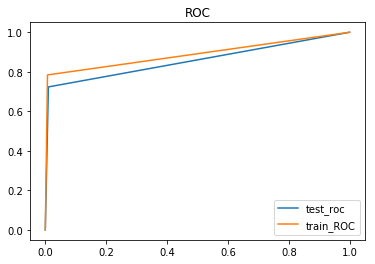


REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      5886
          1       0.92      0.72      0.81      1016

avg / total       0.95      0.95      0.95      6902

ACCURACY =  0.9505940307157346
-----------------
TEST_GROUPS Counter({'6ek0.cif1_L5': 1042, '5o60.cif1_A': 1039, '4wf9.cif1_X': 943, '5j7l.cif1_AA': 649, '4lfb.cif1_A': 587, '6eri.cif1_BA': 541, '5an9.cif1_N': 413, '6az3.cif1_2': 286, '5t2a.cif1_B': 250, '2a64.cif1_A': 61, '5t5h.cif1_D': 55, '3pdr.cif1_X': 51, '5tbw.cif1_AS': 46, '4yaz.cif1_R': 43, '4ycp.cif1_B': 41, '1c0a.cif1_B': 36, '3ndb.cif1_M': 33, '5wt1.cif1_C': 33, '4pr6.cif1_B': 31, '4prf.cif1_B': 31, '3iwn.cif1_A': 29, '4qk9.cif1_A': 28, '2azx.cif1_D': 26, '2qus.cif1_A': 26, '5tbw.cif1_4': 26, '3skl.cif1_B': 25, '5l4o.cif1_A': 25, '5mgp.cif1_x': 25, '1evv.cif1_A': 24, '1qf6.cif1_B': 24, '5o2r.cif1_x': 23, '4rzd.cif1_A': 21, '6gaz.cif1_AV': 21, '5e81.cif1_2K': 20, '5wwt.cif1_C': 20, '6cfj.cif1_1x': 20, '1b23

PROBA:  [0.53299738 0.46700262]

equal


equal


equal


equal

CONFUSION MATRIX By chain:  5x2g.cif1_B
[[9 1]
 [1 0]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5wt1.cif1_C
[[28  0]
 [ 0  5]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  5l4o.cif1_A
[[21  0]
 [ 0  4]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equa

Name: 29321, dtype: object

PROBA:  [0.58287484 0.41712516]

equal

type                                111
dssrs    L5.U.2447.L5.A.2511.L5.A.2743.
bps                           tWH_tWW_-
dists                    9.63_13.6_9.81
Name: 29322, dtype: object

PROBA:  [0.63263432 0.36736568]

equal


equal

type                                111
dssrs    L5.C.2458.L5.G.2463.L5.G.3671.
bps                           cWW_-_cSS
dists                  10.43_12.64_5.64
Name: 29324, dtype: object

PROBA:  [0.54569694 0.45430306]

equal


equal

type                                111
dssrs    L5.U.2485.L5.G.2487.L5.C.2491.
bps                           cWH_cWW_-
dists                    9.53_8.81_12.5
Name: 29326, dtype: object

PROBA:  [0.56139457 0.43860543]

equal

type                                111
dssrs    L5.C.2520.L5.G.2535.L5.G.2640.
bps                           cWW_-_cSS
dists                   10.7_11.56_5.76
Name: 29327, dtype: object

PROBA:  [0.67259915 0.32740085]

equal

type



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                                112
dssrs    2.OMU.667.2.A.1037.2.A2M.1186.
bps                             cWW_-_-
dists                 10.59_50.59_41.44
Name: 27039, dtype: object

PROBA:  [0.43405248 0.56594752]

equal


equal


equal


equal


equal


equal


eq


equal


equal


equal


equal

type                            111
dssrs    B.G.619.B.H2U.620.B.C.656.
bps                       cSH_-_cWW
dists              6.26_11.29_10.62
Name: 43, dtype: object

PROBA:  [0.6593227 0.3406773]

equal


equal


equal


equal


equal


equal


equal


equal


equal

type                            123
dssrs    B.G.610.B.A.624.B.G7M.646.
bps                           -_-_-
dists              13.53_14.16_9.95
Name: 52, dtype: object

PROBA:  [0.40191974 0.59808026]

equal


equal


equal

CONFUSION MATRIX By chain:  1c0a.cif1_B
[[29  1]
 [ 1  5]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


eq

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal






equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                          110
dssrs    1x.A.14.1x.U.20.1x.A.21.
bps                       -_-_cWS
dists             14.73_7.96_9.89
Name: 27380, dtype: object

PROBA:  [0.47550915 0.52449085]

equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  6cfj.cif1_1x
[[16  1]
 [ 0  3]]



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equa



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                         111
dssrs    AV.U.8.AV.A.14.AV.A.18.
bps                  tWH_cWS_tSW
dists            9.75_11.47_8.87
Name: 32786, dtype: object

PROBA:  [0.60207313 0.39792687]

equal


equal


equal


equal


equal


equal


equal


equal


equal

CONFUSION MATRIX By chain:  6gaz.cif1_AV
[[17  0]
 [ 1  3]]



equal

type                       100
dssrs    x.G.10.x.C.24.x.G.27.
bps                      -_-_-
dists         17.18_14.34_7.79
Name: 33481, dtype: object

PROBA:  [0.47189393 0.52810607]

equal


equal


equal

CONFUSION MATRIX By chain:  6ha1.cif1_x
[[2 1]
 [0 1]]



equal


equal


equal


equal

CONFUSION MATRIX By chain:  5xtm.cif1_D
[[3 0]
 [0 1]]



equal


equal


equal


equal


equal


equal

type                          112
dssrs    2K.C.13.2K.G.23.2K.G.46.
bps                       cWW_-_-
dists           10.45_14.36_17.37
Name: 14569, dtype: object

PRO



equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal



PROBA:  [0.76366282 0.23633718]

equal


equal


equal


equal


equal


equal


equal

type                             111
dssrs    A.A.1640.A.A.1714.A.U.1798.
bps                        tWW_-_tHW
dists               13.88_10.32_9.97
Name: 19897, dtype: object

PROBA:  [0.69716141 0.30283859]

equal

type                             111
dssrs    A.G.1642.A.A.1715.A.C.1797.
bps                        tSW_-_cWW
dists                 10.41_9.8_10.8
Name: 19898, dtype: object

PROBA:  [0.6347489 0.3652511]

equal


equal


equal

type                             111
dssrs    A.U.1695.A.G.1738.A.C.1949.
bps                        -_cWW_cSH
dists               12.74_10.35_8.77
Name: 19901, dtype: object

PROBA:  [0.83690903 0.16309097]

equal

type                             111
dssrs    A.G.1878.A.C.2224.A.U.2913.
bps                        cWW_-_...
dists               10.66_7.78_11.62
Name: 19902, dtype: object

PROBA:  [0.67386129 0.32613871]

equal


equal


equal


equal


equal




equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal


equal





PROBA:  [0.64904005 0.35095995]

equal

type                             111
dssrs    X.G.1820.X.U.1861.X.A.1927.
bps                        -_cWH_tSW
dists                 12.29_9.29_9.0
Name: 12148, dtype: object

PROBA:  [0.91797358 0.08202642]

equal


equal


equal

type                             111
dssrs    X.A.1916.X.U.2113.X.A.2260.
bps                        cSS_cWW_-
dists               5.97_10.25_11.12
Name: 12151, dtype: object

PROBA:  [0.8093523 0.1906477]

equal


equal


equal

type                             111
dssrs    X.C.2074.X.G.2648.X.A.2843.
bps                        cWW_-_cSW
dists               10.72_11.64_9.89
Name: 12154, dtype: object

PROBA:  [0.56385124 0.43614876]

equal


equal


equal


equal


equal


equal


equal


equal


equal


equal

type                             111
dssrs    X.C.2288.X.G.2306.X.A.2354.
bps                      cWW_cSS_tSW
dists                10.48_5.97_8.27
Name: 12164, dtype: object

PROBA:  [0.64562427 0.35437573]



AUC_TRAIN =  0.8751486325802617

AUC =  0.8608675218141668


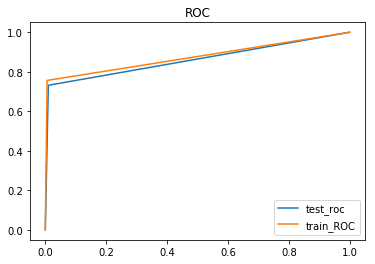


REPORT
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      5888
          1       0.93      0.73      0.82      1014

avg / total       0.95      0.95      0.95      6902

ACCURACY =  0.9520428861199652
-----------------


In [10]:
groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=5)
#group_kfold.get_n_splits(X, y, groups)

description = ['type', 'dssrs', 'bps', 'dists']

for train_index, test_index in group_kfold.split(triplexes, triplexes_target, groups):
    #triplexes_data = triplexes.iloc[:, 5:475]
    #print(triplexes_data)
    X_train_middle, X_test_middle = triplexes.loc[list(train_index)], triplexes.loc[test_index]
    X_train = X_train_middle.iloc[:, 5:475]
    X_test = X_test_middle.iloc[:, 5:475]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]

    
    a = Counter(list(triplexes.loc[list(train_index)].pdb_chain.values))
    b = Counter(list(triplexes.loc[list(test_index)].pdb_chain.values))
    
    for key in a:
        if key in b.keys():
            print("FUUUUUUUUU")
    print("TEST_GROUPS", Counter(list(triplexes.pdb_chain.loc[test_index])))
    rf_classifier_cv.fit(X_train, y_train)
    
    #prediction by chains
    chains = list(set(X_test_middle.pdb_chain.values))

    print("")
    for chain in chains:
        middle_check_test = X_test_middle.loc[X_test_middle['pdb_chain'] == chain]
        middle_target_test = middle_check_test['istriple']
        middle_check_test_ = middle_check_test.iloc[:, 5:475]
    
        prediction_result_by_chain = rf_classifier_cv.predict(middle_check_test_)
        predict_proba_by_chain = rf_classifier_cv.predict_proba(middle_check_test_)
        print("")

        
        #PREDICTED PROBABILITIES
        i = 0
        for index, row in middle_check_test.iterrows():
            if middle_target_test[index] != prediction_result_by_chain[i]:
                print(row[description])
                print("")
                print("PROBA: ", predict_proba_by_chain[i])
            i = i + 1
            print("")
            print("equal")
            print("")

        print("CONFUSION MATRIX By chain: ", chain)
        print(confusion_matrix(middle_target_test, prediction_result_by_chain))
        print("")
    
    #simple prediction
    prediction_result = rf_classifier_cv.predict(X_test)
    prediction_prob = rf_classifier_cv.predict_proba(X_test)
    
    #TRY TO PREDICT TRAIN
    prediction_train = rf_classifier_cv.predict(X_train)
    fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  prediction_train)
    auc_train = metrics.roc_auc_score(y_train, prediction_train)
    print("AUC_TRAIN = ", auc_train)
    
    #---------------------------------
    print("")
    fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_result)
    auc = metrics.roc_auc_score(y_test, prediction_result)
    print("AUC = ", auc)
    line_test, = plt.plot(fpr, tpr, label='test_roc')
    line_train, = plt.plot(fpr_train, tpr_train, label='train_roc')
    plt.legend( [line_test, line_train], ['test_roc', 'train_ROC'], loc = 4)
    plt.title("ROC")
    plt.show()


    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY = ", accuracy_score(y_test, prediction_result))
    print("-----------------")


[[5829   59]
 [ 272  742]]
CONFUSION MATRIX
Predicted     0    1   All
Actual                    
0          5829   59  5888
1           272  742  1014
All        6101  801  6902


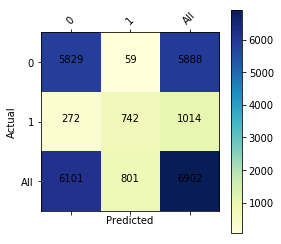

In [11]:
print(confusion_matrix(y_test, prediction_result))
plot_confusion_matrix(pd.crosstab(y_test, prediction_result, rownames=['Actual'], colnames=['Predicted'], margins=True))

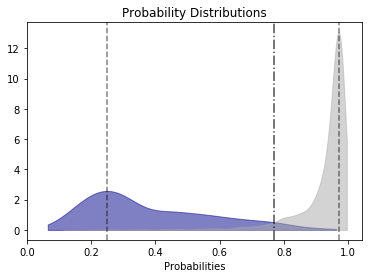

In [12]:
probability_density(prediction_prob[:, 0], y_test)

In [13]:
# 10 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=10)
#group_kfold.get_n_splits(X, y, groups)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    print("CONFUSION MATRIX")
    print(confusion_matrix(y_test, prediction_result))
    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")


TRAIN: [    0     1     2 ... 34507 34508 34509] TEST: [   55    56    57 ... 28630 28631 28632]

CONFUSION MATRIX
[[2914   28]
 [ 172  337]]

REPORT
             precision    recall  f1-score   support

          0       0.94      0.99      0.97      2942
          1       0.92      0.66      0.77       509

avg / total       0.94      0.94      0.94      3451

ACCURACY 0.9420457838307736
-----------------
TRAIN: [   19    20    21 ... 34507 34508 34509] TEST: [    0     1     2 ... 33436 33437 33438]

CONFUSION MATRIX
[[2913   34]
 [ 150  354]]

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      2947
          1       0.91      0.70      0.79       504

avg / total       0.95      0.95      0.94      3451

ACCURACY 0.9466821211243118
-----------------
TRAIN: [    0     1     2 ... 34507 34508 34509] TEST: [  240   241   242 ... 30355 30356 30357]

CONFUSION MATRIX
[[2898   43]
 [ 129  381]]

REPORT
             precision    re

In [14]:
# 15 фолдов

groups = np.array(triplexes.pdb_chain.values)
group_kfold = GroupKFold(n_splits=15)

for train_index, test_index in group_kfold.split(triplexes_data, triplexes_target, groups):
    print("TRAIN:", train_index, "TEST:", test_index)
    print("")
    X_train, X_test = triplexes_data.loc[list(train_index)], triplexes_data.loc[test_index]
    y_train, y_test = triplexes_target.loc[train_index], triplexes_target.loc[test_index]
    rf_classifier_cv.fit(X_train, y_train)
    prediction_result = rf_classifier_cv.predict(X_test)
    print("CONFUSION MATRIX")
    print(confusion_matrix(y_test, prediction_result))
    print("")
    print("REPORT")
    print(classification_report(y_test, prediction_result))
    print("ACCURACY", accuracy_score(y_test, prediction_result))
    print("-----------------")


TRAIN: [    0     1     2 ... 34507 34508 34509] TEST: [  297   298   299 ... 29694 29695 29696]

CONFUSION MATRIX
[[1932   28]
 [ 112  229]]

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1960
          1       0.89      0.67      0.77       341

avg / total       0.94      0.94      0.94      2301

ACCURACY 0.9391568883094307
-----------------
TRAIN: [    0     1     2 ... 34507 34508 34509] TEST: [  174   175   176 ... 32792 32793 32794]

CONFUSION MATRIX
[[1938   23]
 [  95  244]]

REPORT
             precision    recall  f1-score   support

          0       0.95      0.99      0.97      1961
          1       0.91      0.72      0.81       339

avg / total       0.95      0.95      0.95      2300

ACCURACY 0.948695652173913
-----------------
TRAIN: [    0     1     2 ... 34504 34505 34506] TEST: [  240   241   242 ... 34507 34508 34509]

CONFUSION MATRIX
[[1949   15]
 [ 104  233]]

REPORT
             precision    rec